For this project we will attempt to create a model that predcits the daily and cumulative price change of Applied Materials (AMAT) stock.

C:\Users\sarah\AppData\Local\Temp\ipykernel_17388\4050854090.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


2139
Mean price difference = 0.0106814315729699, Std of price difference = 0.30078732811264264


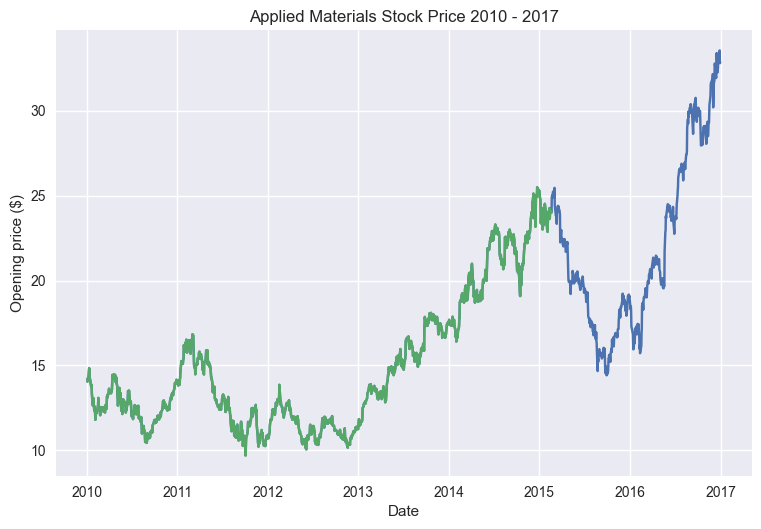

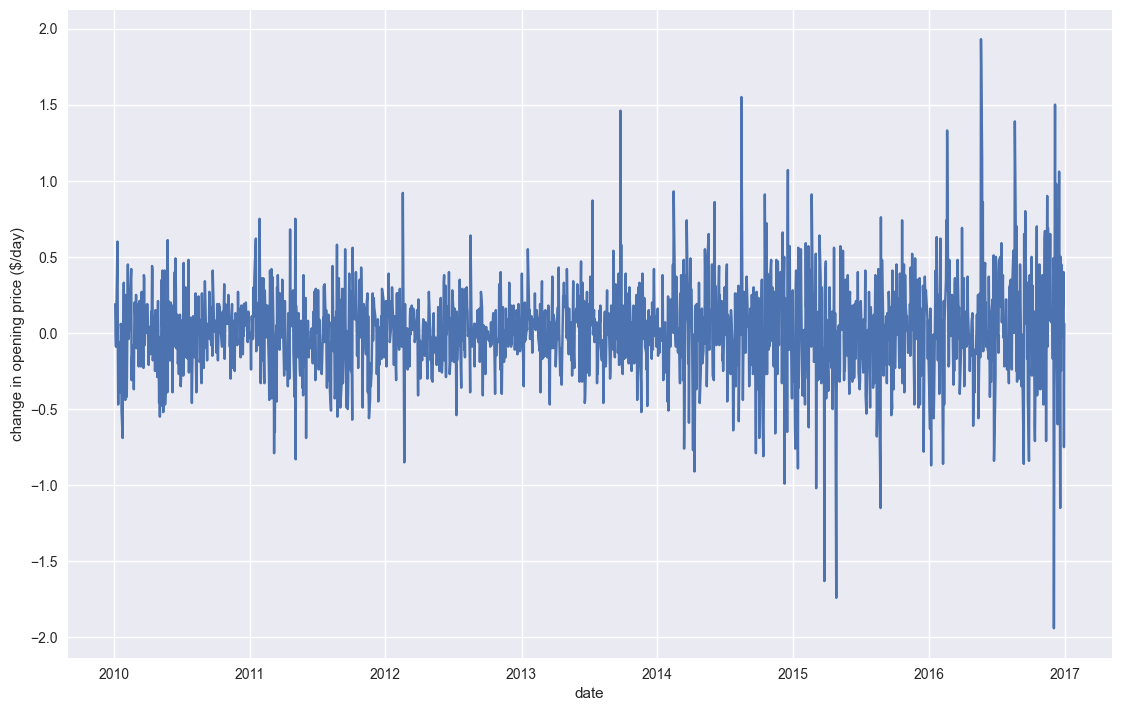

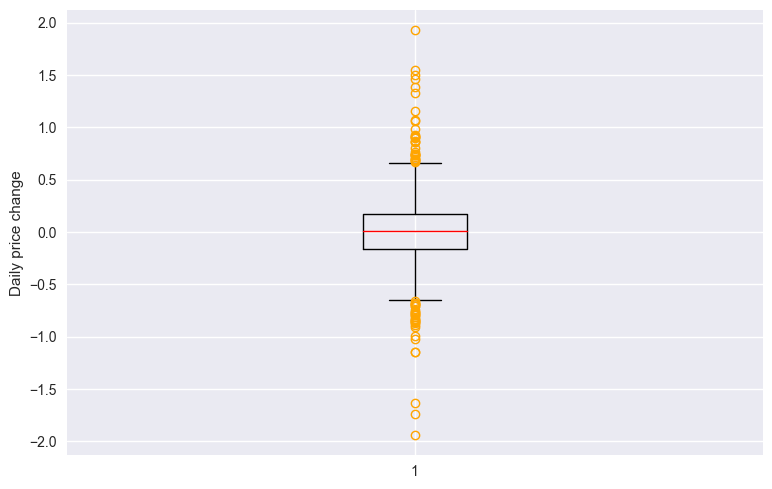

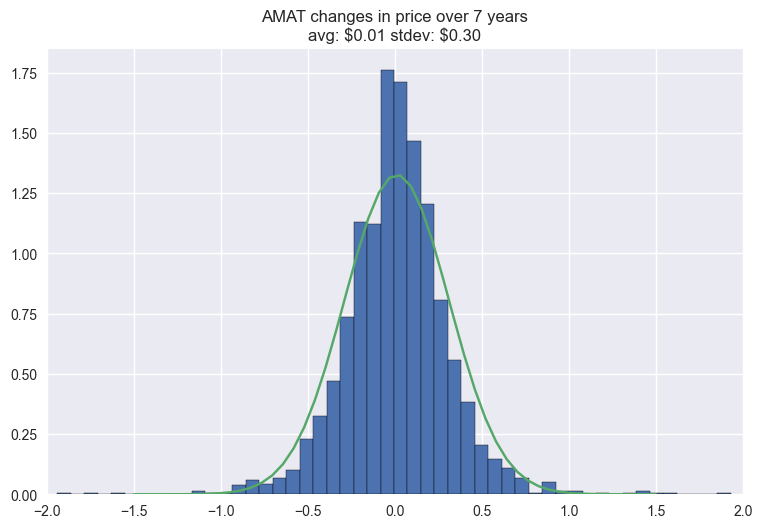

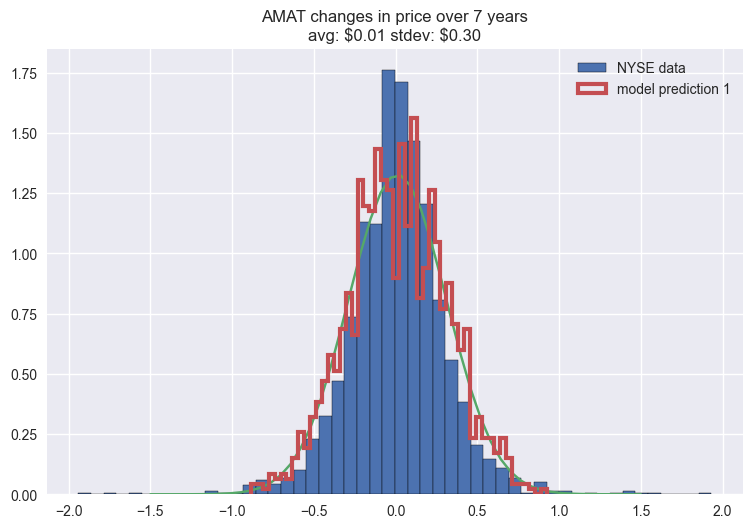

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn')
from numpy.random import default_rng

url = "https://raw.githubusercontent.com/Uconnpem/CompMech/master/data/nyse-data.csv"

#data = pd.read_csv(url)
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d', errors = 'coerce')

null_values_count = data['date'].isna().sum() # yields 2139 null values, negligible given the 800,000+ in the original set
print(null_values_count)
AMAT_data = data[data['symbol'] == 'AMAT']

plt.plot(AMAT_data['date'], AMAT_data['open']);

AMAT_data_pre_2015 = AMAT_data[ AMAT_data['date'] < pd.to_datetime('2015-02-20')]


plt.plot(AMAT_data_pre_2015['date'], AMAT_data_pre_2015['open']);

plt.xlabel('Date')
plt.ylabel('Opening price (\$)');
plt.title('Applied Materials Stock Price 2010 - 2017');

dprice = np.diff(AMAT_data['open'])
plt.figure(figsize = (12,8))
plt.plot(AMAT_data['date'][1:], dprice)
plt.xlabel('date')
plt.ylabel('change in opening price (\$/day)');

plt.figure()
plt.boxplot(dprice, boxprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            medianprops=dict(color='red'),
            capprops=dict(color='black'),
            flierprops=dict(markeredgecolor='orange'))
plt.ylabel("Daily price change")
# Full span of data
dprice1 = np.diff(AMAT_data['open'])
mean_dprice1 = np.mean(dprice1)
std_dprice1 = np.std(dprice1)
x = np.linspace(-1.5, 1.5)
from scipy import stats
price_pdf1 = stats.norm.pdf(x, loc = mean_dprice1, scale = std_dprice1)
print(f"Mean price difference = {mean_dprice1}, Std of price difference = {std_dprice1}")

plt.figure()
plt.hist(dprice1, 50, density=True, edgecolor = 'black')
plt.plot(x, price_pdf1)
plt.xlim(-2,2)
plt.title('AMAT changes in price over 7 years\n'+
         'avg: \${:.2f} stdev: \${:.2f}'.format(mean_dprice1, std_dprice1));

rng = default_rng(17)   
N_models = 100
dprice_model = rng.normal(size = (len(AMAT_data_pre_2015), N_models), loc = mean_dprice1, scale = std_dprice1)

plt.figure()
plt.hist(dprice, 50, density=True, label = 'NYSE data', edgecolor = 'black')
plt.plot(x, price_pdf1)
plt.hist(dprice_model[:, 0], 50, density = True, 
         histtype = 'step', 
         linewidth = 3, label = 'model prediction 1')
plt.title('AMAT changes in price over 7 years\n'+
         'avg: \${:.2f} stdev: \${:.2f}'.format(mean_dprice1, std_dprice1))
plt.legend();



This model looks reasonably accurate. The boxplot is fairly symmetrical (indicative of a normal distribution) and our price change model fits the real data quite well but I think we can improve it by removing the data following the drop in 2015.

Mean price difference = 0.00772093023255814, Std of price difference = 0.25902187946744243


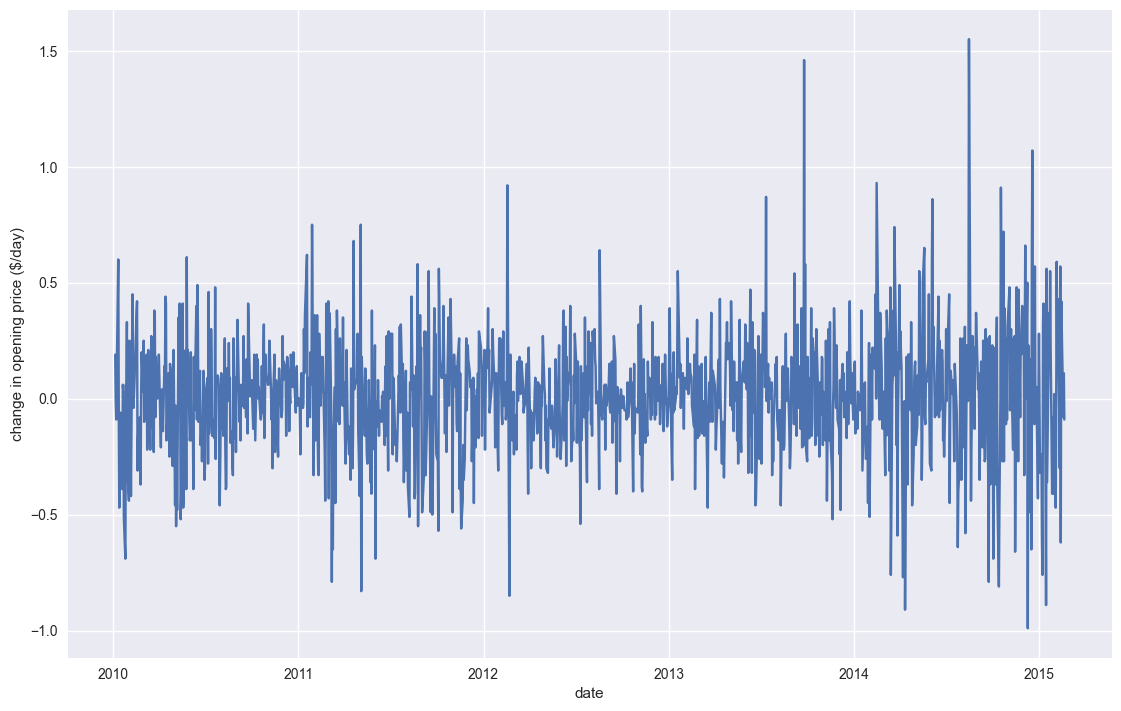

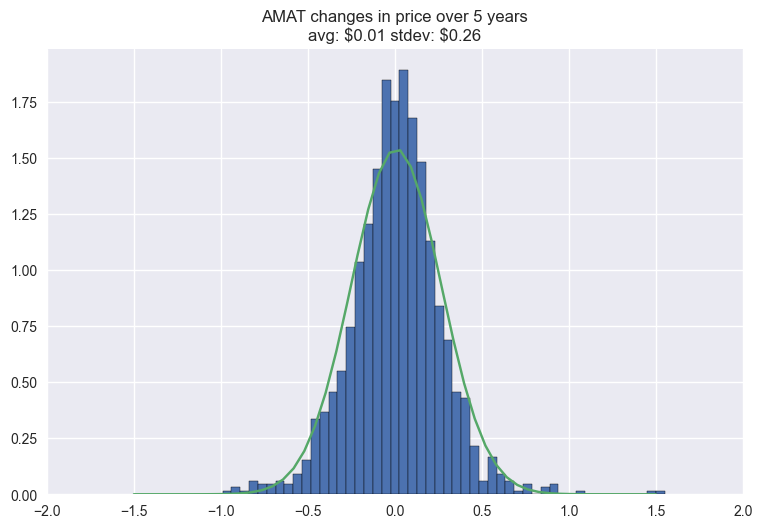

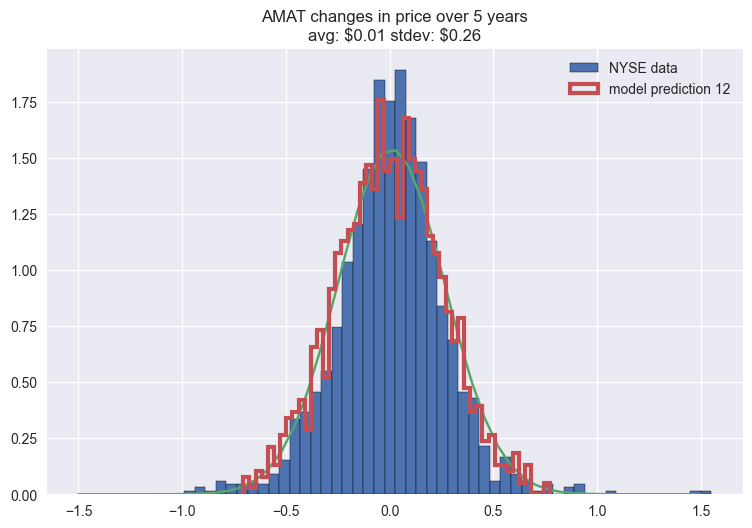

In [122]:
dprice = np.diff(AMAT_data_pre_2015['open'])
plt.figure(figsize = (12,8))
plt.plot(AMAT_data_pre_2015['date'][1:], dprice)
plt.xlabel('date')
plt.ylabel('change in opening price (\$/day)');


mean_dprice = np.mean(dprice)
std_dprice = np.std(dprice)
x = np.linspace(-1.5, 1.5)
from scipy import stats
price_pdf = stats.norm.pdf(x, loc = mean_dprice, scale = std_dprice)
print(f"Mean price difference = {mean_dprice}, Std of price difference = {std_dprice}")

plt.figure()
plt.hist(dprice, 50, density=True, edgecolor = 'black')
plt.plot(x, price_pdf)
plt.xlim(-2,2)
plt.title('AMAT changes in price over 5 years\n'+
         'avg: \${:.2f} stdev: \${:.2f}'.format(mean_dprice, std_dprice));

rng = default_rng(17)
N_models = 100
dprice_model = rng.normal(size = (len(AMAT_data_pre_2015), N_models), loc = mean_dprice, scale = std_dprice)

plt.figure()
plt.hist(dprice, 50, density=True, label = 'NYSE data', edgecolor = 'black')
plt.plot(x, price_pdf)
plt.hist(dprice_model[:, 11], 50, density = True, 
         histtype = 'step', 
         linewidth = 3, label = 'model prediction 12')
plt.title('AMAT changes in price over 5 years\n'+
         'avg: \${:.2f} stdev: \${:.2f}'.format(mean_dprice, std_dprice))
plt.legend();


We can see here that the mean and standard deviation of the daily price change is smaller, which is likely due to the growth trend in the company's stock price. This growth in price would lead to the same percentage change in a day resulting in a larger absolute change, so the difference in mean and std from the first set of plots to the second isn't necessarily a result of an increase in volatility, but rather an increase in the absolute price of the stock.

I'll now create a model to predict the price of AMAT's stock, which will be a cumulative sum of the previous model used for daily price difference.

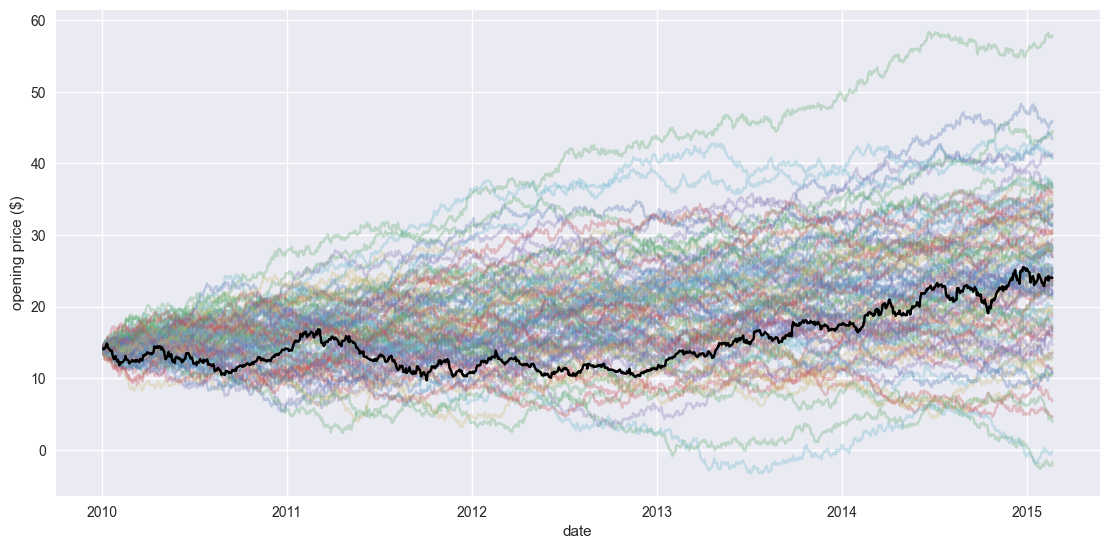

In [123]:
price_model = np.cumsum(dprice_model, axis = 0) + AMAT_data_pre_2015['open'].values[0]

plt.figure(figsize = (12,6))
plt.plot(AMAT_data_pre_2015['date'], price_model, alpha = 0.3);

plt.plot(AMAT_data_pre_2015['date'], AMAT_data_pre_2015['open'], c = 'k', label = 'NYSE data')
plt.xlabel('date')
plt.ylabel('opening price (\$)');


And here's a plot comparing the mean result of all 100 random models with the actual data.

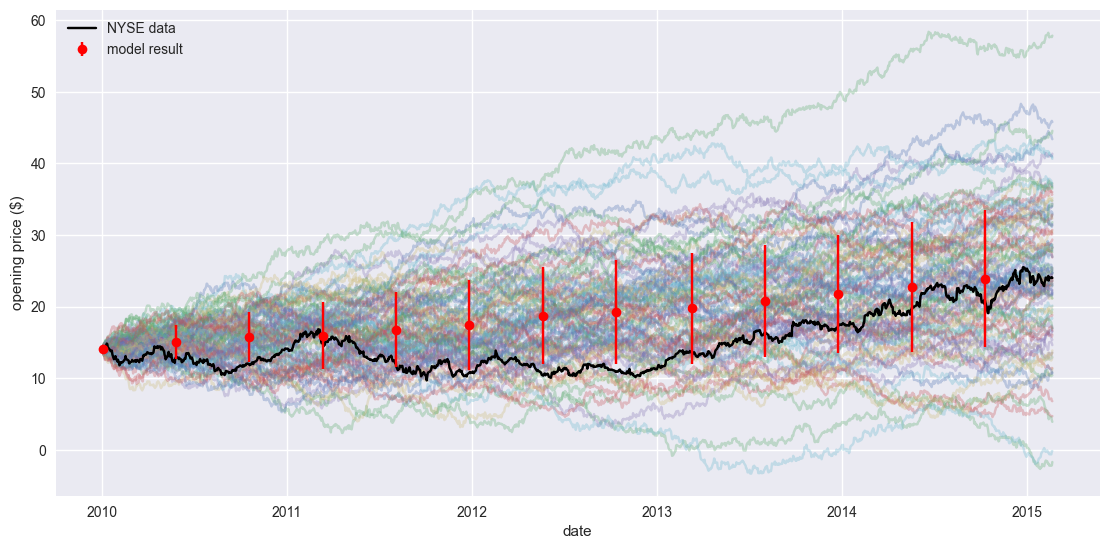

In [124]:
price_model_avg = np.mean(price_model, axis = 1)
price_model_std = np.std(price_model, axis = 1)

plt.figure(figsize = (12,6))
plt.plot(AMAT_data_pre_2015['date'], price_model, alpha = 0.3);

plt.plot(AMAT_data_pre_2015['date'], AMAT_data_pre_2015['open'], c = 'k', label = 'NYSE data')
plt.xlabel('date')
plt.ylabel('opening price (\$)');

skip = 100
plt.errorbar(AMAT_data_pre_2015['date'][::skip], price_model_avg[::skip],
             yerr = price_model_std[::skip], 
             fmt = 'o',
             c = 'r', 
             label = 'model result', 
            zorder = 3);
plt.legend()


Our second model seems to be a reasonably good predictor of the actual data, however it's far from perfect. This probably stems from the assumption that the daily change in stock price is random and normally distributed, which can't be 100% accurate, for a number of reasons.

    1) There are real world variables involved which may help to predict the large single day price changes. These outliers cause our calculated standard deviation to be higher than it would be based on random price changes, and the model is noticably better with a slightly lower standard deviation (std*0.9).

    2) Stock prices grow exponentially in the long run, not linearly, and our model doesn't take this into account at all. Again this would result in an overestimation of the standard deviation of daily price changes, which leads to a less accurate model. 